In [1]:
import itertools
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import pyreadr
import random
import time
import datetime as dt
import matplotlib.pyplot as plt

from operator import itemgetter
from sklearn import metrics, preprocessing
from sklearn.metrics import average_precision_score, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, roc_curve, auc, recall_score, precision_score, f1_score, precision_recall_curve, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBClassifier, XGBRegressor, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from matplotlib import pyplot
from numpy import genfromtxt

import keras
import keras_tuner

from keras import Sequential
from keras.applications import DenseNet121  # Import DenseNet model directly
from keras.layers import Dense, Dropout, Flatten, LSTM, Embedding  # Import layers from keras.layers

pd.options.mode.chained_assignment = None 

arialfont = {'fontname':'Arial'}

import warnings

# Ignore Warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
location = "E:\\Work\\UPO Sevilla\\Paper2_Data_Oct24"
matrices = "\\matrices\\"
output = "\\output"

# Binary classification

## Load datasets

In [3]:
loc_HEK293_neg = location + matrices + "HEK293\\HEK293_neg.csv"
loc_HEK293_pos = location + matrices + "HEK293\\HEK293_pos.csv"

loc_HeLa_neg = location + matrices + "HeLa\\HeLa_neg.csv"
loc_HeLa_pos = location + matrices + "HeLa\\HeLa_pos.csv"

loc_K562_neg = location + matrices + "K562\\K562_neg.csv"
loc_K562_pos = location + matrices + "K562\\K562_pos.csv"

In [4]:
df_HEK293_neg = pd.read_csv(loc_HEK293_neg, sep='\t')
df_HEK293_pos = pd.read_csv(loc_HEK293_pos, sep='\t')

df_HeLa_neg = pd.read_csv(loc_HeLa_neg, sep='\t')
df_HeLa_pos = pd.read_csv(loc_HeLa_pos, sep='\t')

df_K562_neg = pd.read_csv(loc_K562_neg, sep='\t')
df_K562_pos = pd.read_csv(loc_K562_pos, sep='\t')

In [5]:
df_HEK293_neg["CLASS"] = 0
df_HEK293_pos["CLASS"] = 1

df_HeLa_neg["CLASS"] = 0
df_HeLa_pos["CLASS"] = 1

df_K562_neg["CLASS"] = 0
df_K562_pos["CLASS"] = 1

In [6]:
df_HEK293 = pd.concat([df_HEK293_neg, df_HEK293_pos])
df_HeLa = pd.concat([df_HeLa_neg, df_HeLa_pos])
df_K562 = pd.concat([df_K562_neg, df_K562_pos])

In [7]:
df_HEK293

,H3K4me3,H3K36me3,H3K9me3,H3K4me1,H3K27ac,H3K27me3,H3K9ac,RNAseq,DNase,GROseq,deepRloop,RLFS,GC,CTCF,RAD21,CLASS
0,0.046,0.043,0.036,0.030,0.011,0.053,0.006,0.004,0.004,0.000,2.920,0,0.406,0.051,0.080,0
1,0.039,0.039,0.041,0.022,0.007,0.047,0.042,0.000,0.009,0.000,0.079,0,0.324,0.000,0.055,0
2,0.048,0.045,0.032,0.022,0.004,0.065,0.026,0.000,0.007,0.000,0.295,0,0.474,0.000,0.055,0
3,0.043,0.039,0.032,0.022,0.004,0.209,0.028,0.000,0.013,0.000,0.328,2,0.578,0.051,0.055,0
4,0.039,0.041,0.054,0.029,0.018,0.043,0.005,0.014,0.005,0.056,0.527,0,0.332,0.051,0.058,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5934,0.712,0.000,0.032,0.000,0.792,0.051,0.675,0.530,0.328,0.238,0.242,1,0.720,0.054,0.136,1
5935,0.816,0.039,0.032,0.073,1.140,0.050,0.768,0.677,0.231,0.256,0.232,1,0.662,0.062,0.141,1
5936,0.039,0.069,0.036,0.022,0.024,0.038,0.039,0.250,0.011,0.072,0.497,0,0.348,0.059,0.090,1
5937,0.058,0.086,0.044,0.030,0.051,0.046,0.029,0.317,0.009,0.056,0.234,0,0.432,0.051,0.087,1


## Preprocessing

In [8]:
X_train_HEK293, X_test_HEK293  = train_test_split(df_HEK293, test_size=0.3, shuffle=True, random_state=42)
X_train_HeLa, X_test_HeLa = train_test_split(df_HeLa, test_size=0.3, shuffle=True, random_state=42)
X_train_K562, X_test_K562  = train_test_split(df_K562, test_size=0.3, shuffle=True, random_state=42)

In [9]:
df_K562_HEK293 = pd.concat([df_K562, df_HEK293])
df_K562_HeLa = pd.concat([df_K562, df_HeLa])
df_HEK293_HeLa = pd.concat([df_HEK293, df_HeLa])

## Optimal parameter search

In [12]:
import os
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from itertools import product
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, precision_score, recall_score, auc, roc_curve, precision_recall_curve, accuracy_score, balanced_accuracy_score, matthews_corrcoef
from sklearn.model_selection import ParameterGrid
import joblib
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Define models
models = {
    'RF': RandomForestClassifier(random_state=42),
    'XGB': XGBClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'LogReg': LogisticRegression(random_state=42),
    'GBM': GradientBoostingClassifier(random_state=42),
    'MLP': MLPClassifier(random_state=42),
    'NaiveBayes': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
}

# Define parameter grids
param_grids = {
    'RF': ParameterGrid({
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }),
    'XGB': ParameterGrid({
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [6, 10, 15, 20],
        # 0.1 is optimal, skipping the rest for performance
        'learning_rate': [0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.7, 0.9],
        'gamma': [0, 0.5, 1.0],
        'reg_lambda': [1.0, 10.0, 50.0],
    }),
    'KNN': ParameterGrid({
        'n_neighbors': [5, 10, 15, 20],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }),
    'AdaBoost': ParameterGrid({
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.1, 0.5, 1.0]
    }),
    'LogReg': ParameterGrid({
        'C': [0.1, 1.0, 10.0],
        'solver': ['liblinear'],
        'max_iter': [100, 200]
    }),
    'GBM': ParameterGrid({
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.1, 0.2, 0.3],
        'max_depth': [3, 6, 9]
    }),
    'MLP': ParameterGrid({
        'hidden_layer_sizes': [(100,), (100, 100), (200,), (200, 100)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
    }),
    'NaiveBayes': ParameterGrid({}),
    'DecisionTree': ParameterGrid({
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }),
}

In [14]:
# Create directories for outputs if they don't exist
os.makedirs("output", exist_ok=True)
os.makedirs("models", exist_ok=True)

# Define training-validation dataset pairs
dataset_pairs = [
    ("K562_to_K562", X_train_K562, X_test_K562),
    ("HEK293_to_HEK293", X_train_HEK293, X_test_HEK293),
    ("HeLa_to_HeLa", X_train_HeLa, X_test_HeLa),
    ("K562_HEK293_to_HeLa", df_K562_HEK293, df_HeLa),
    ("K562_HeLa_to_HEK293", df_K562_HeLa, df_HEK293),
    ("HEK293_HeLa_to_K562", df_HEK293_HeLa, df_K562)
]

results = []

# Define a new results dictionary for each model
results = {model: [] for model in models.keys()}

# For storing the best model of each type for each dataset pair
pair_best_model = {pair[0]: {} for pair in dataset_pairs}

# Loop through dataset pairs
for pair_name, X_train_full, X_val_full in dataset_pairs:
    X_train, y_train = X_train_full.drop("CLASS", axis=1), X_train_full["CLASS"]
    X_val, y_val = X_val_full.drop("CLASS", axis=1), X_val_full["CLASS"]

    # Get feature names from the dataframe
    feature_names = X_train.columns.tolist()

    # Loop through models
    for model in models.keys():
        print(f"\nStarting grid search for {model} on {pair_name}")

        param_grid_size = len(param_grids[model])
        next_print_percentage = 2.5
        start_time = time.time()

        best_model = None
        best_f1 = -np.inf

        # Loop through parameter grid
        for j, params in enumerate(param_grids[model]):
            param_start_time = time.time()
            clf = models[model].__class__()
            clf.set_params(**params)
            clf.fit(X_train, y_train)

            preds = clf.predict(X_val)
            f1 = round(f1_score(y_val, preds, average='macro')*100, 2)
            precision = round(precision_score(y_val, preds, average='macro')*100, 2)
            recall = round(recall_score(y_val, preds, average='macro')*100, 2)
            accuracy = round(accuracy_score(y_val, preds)*100, 2)
            balanced_accuracy = round(balanced_accuracy_score(y_val, preds)*100, 2)
            matthews_corrcoef_score = round(matthews_corrcoef(y_val, preds)*100, 2)


            # Update best model if current model is better
            if f1 > best_f1:
                best_model = clf
                best_f1 = f1

            auc_roc = round(auc(*roc_curve(y_val, clf.predict_proba(X_val)[:, 1])[:2])*100, 2)
            precision_curve, recall_curve, _ = precision_recall_curve(y_val, clf.predict_proba(X_val)[:, 1])
            sort_indices = np.argsort(recall_curve)
            precision_sorted = precision_curve[sort_indices]
            recall_sorted = recall_curve[sort_indices]
            auc_pr = round(auc(recall_sorted, precision_sorted)*100, 2)

            # Get importances if the model has feature_importances_ attribute
            importances = (clf.feature_importances_*100 if hasattr(clf, "feature_importances_") else None)
           
            # Create a dictionary for current results
            current_result = {
                "model": model,
                "dataset_pair": pair_name,
                "parameters": json.dumps(params),
                "precision": precision,
                "recall": recall,
                "f1_score": f1,
                "accuracy": accuracy,
                "balanced_accuracy": balanced_accuracy,
                "matthews_corrcoef": matthews_corrcoef_score,
                "auc_roc": auc_roc,
                "auc_pr": auc_pr,
                "feature_importances": json.dumps({name: importance for name, importance in zip(feature_names, importances.tolist())}) if importances is not None else None
            }
            
            # Save results
            results[model].append(current_result)
            
            # Print status update every 2.5%
            completion_percentage = ((j + 1) / param_grid_size) * 100
            if completion_percentage >= next_print_percentage:
                elapsed_time = time.time() - param_start_time
                estimated_time_remaining = timedelta(seconds=(elapsed_time * (param_grid_size - (j + 1))))
                estimated_time_remaining_str = datetime(1,1,1) + estimated_time_remaining  # Convert timedelta to datetime
                print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - {model} on {pair_name}: {completion_percentage:.2f}% complete, estimated time remaining: {estimated_time_remaining_str.strftime('%H:%M:%S')}")
                next_print_percentage += 2.5
            
        pair_best_model[pair_name][model] = best_model


Starting grid search for RF on K562_to_K562
2024-12-19 16:07:14 - RF on K562_to_K562: 2.78% complete, estimated time remaining: 00:04:56
2024-12-19 16:07:26 - RF on K562_to_K562: 5.09% complete, estimated time remaining: 00:09:05
2024-12-19 16:07:39 - RF on K562_to_K562: 7.87% complete, estimated time remaining: 00:02:17
2024-12-19 16:07:49 - RF on K562_to_K562: 10.19% complete, estimated time remaining: 00:04:12
2024-12-19 16:08:00 - RF on K562_to_K562: 12.50% complete, estimated time remaining: 00:07:47
2024-12-19 16:08:12 - RF on K562_to_K562: 15.28% complete, estimated time remaining: 00:01:56
2024-12-19 16:08:22 - RF on K562_to_K562: 17.59% complete, estimated time remaining: 00:03:36
2024-12-19 16:08:36 - RF on K562_to_K562: 20.37% complete, estimated time remaining: 00:10:25
2024-12-19 16:08:44 - RF on K562_to_K562: 22.69% complete, estimated time remaining: 00:01:41
2024-12-19 16:08:53 - RF on K562_to_K562: 25.00% complete, estimated time remaining: 00:03:11
2024-12-19 16:09:0

In [15]:
# Save intermediate results to CSV files per model and dataset pair
for model, model_results in results.items():
    # Before converting results to DataFrame, sort feature_importance values
    for result in model_results:
        feature_importances = result['feature_importances']
        if feature_importances is not None:
            # Parse JSON string into dict
            feature_importance_dict = json.loads(feature_importances)
            # Convert dict to list of tuples, sort by feature importance value, and convert back to dict
            feature_importance_list = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
            result['feature_importances'] = json.dumps(dict(feature_importance_list))

    # Convert results to DataFrame and sort by F1 score
    results_df = pd.DataFrame(model_results)
    results_df = results_df.sort_values(by='f1_score', ascending=False)
    csv_file_path = os.path.join("output", f"results_{model}.csv")
    results_df.to_csv(csv_file_path, index=False)
    # print(f"The CSV file for {model} was created successfully here: {os.path.abspath(csv_file_path)}")
    
# Initialize dictionary to store best model results for each pair
best_results = {}

# Loop through each model and their results
for model, model_results in results.items():
    # Convert model results to DataFrame for easier manipulation
    model_results_df = pd.DataFrame(model_results)
    
    # Loop through each dataset pair
    for pair in model_results_df['dataset_pair'].unique():
        # Filter the results for the current pair
        pair_results_df = model_results_df[model_results_df['dataset_pair'] == pair]
        
        # If there are results for this pair
        if not pair_results_df.empty:
            # Get the row with the highest F1 score
            best_result_row = pair_results_df.loc[pair_results_df['f1_score'].idxmax()]
            
            # Add the best result row to the pair's best models
            if pair not in best_results:
                best_results[pair] = []
            best_results[pair].append(best_result_row)

# Save the best models for each pair to a separate CSV file
for pair, best_models in best_results.items():
    best_models_df = pd.DataFrame(best_models)
    csv_file_path = os.path.join("output", f"best_{pair}.csv")
    best_models_df.to_csv(csv_file_path, index=False)
    # print(f"The CSV file for {pair} was created successfully here: {os.path.abspath(csv_file_path)}")

# Combine results and save to a single CSV file
combined_results = []
for model_results in results.values():
    combined_results.extend(model_results)
combined_results_df = pd.DataFrame(combined_results)
combined_csv_file_path = os.path.join("output", "combined_results.csv")
combined_results_df.to_csv(combined_csv_file_path, index=False)
# print(f"The combined CSV file was created successfully here: {os.path.abspath(combined_csv_file_path)}")

# For saving the best model of each type for each dataset pair
for pair, pair_results in pair_best_model.items():
    for model_name, best_model in pair_results.items():
        model_file_path = os.path.join("models", f"{pair}_{model_name}_best_model.pkl")
        joblib.dump(best_model, model_file_path)
        # print(f"The best model file for {model_name} on {pair} was created successfully here: {os.path.abspath(model_file_path)}")

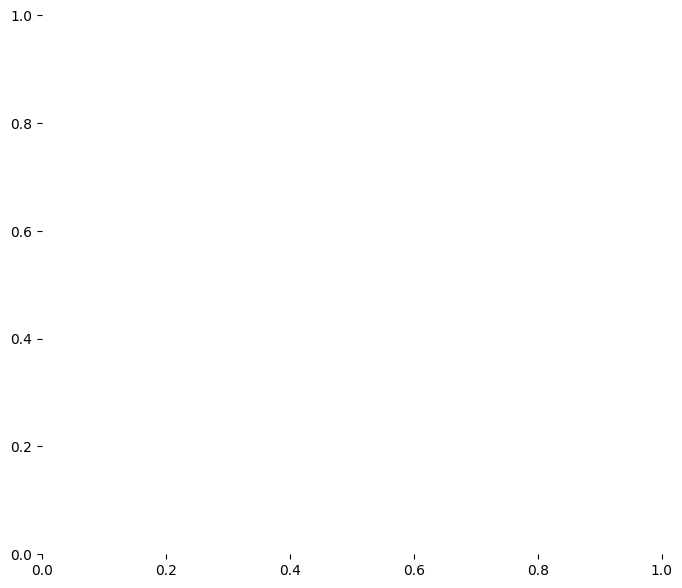

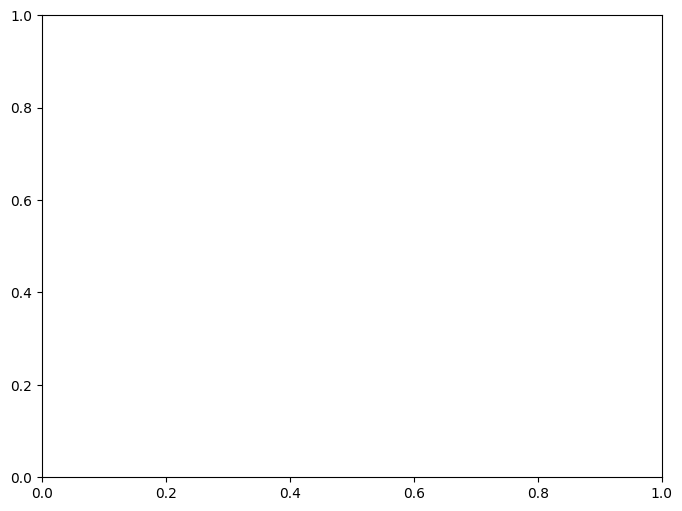

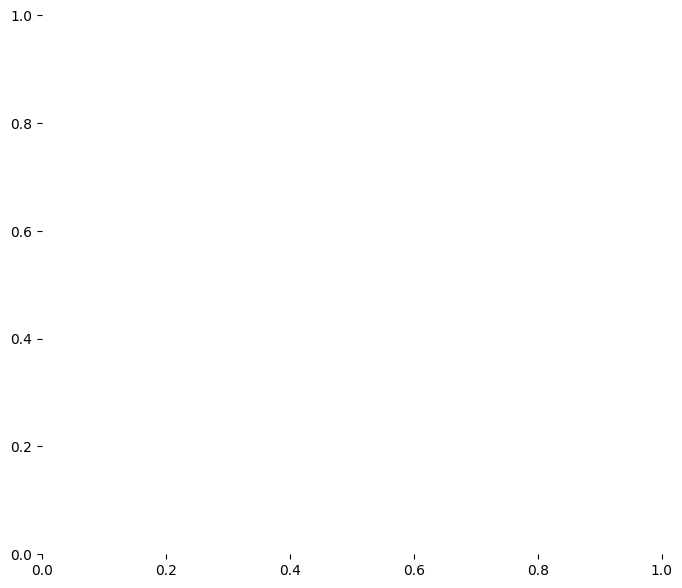

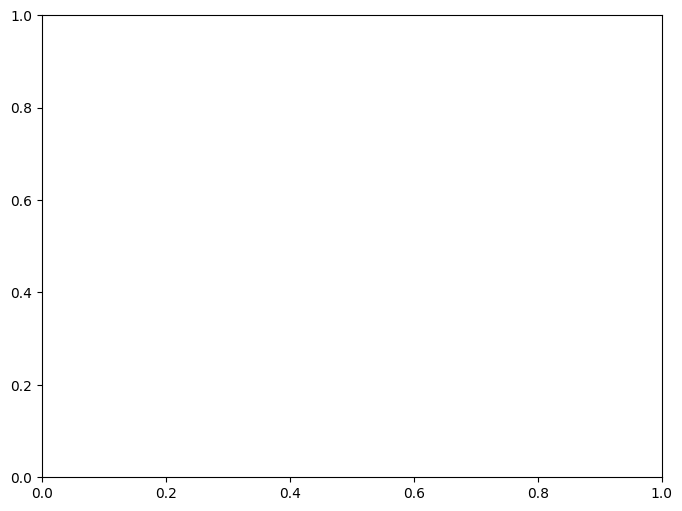

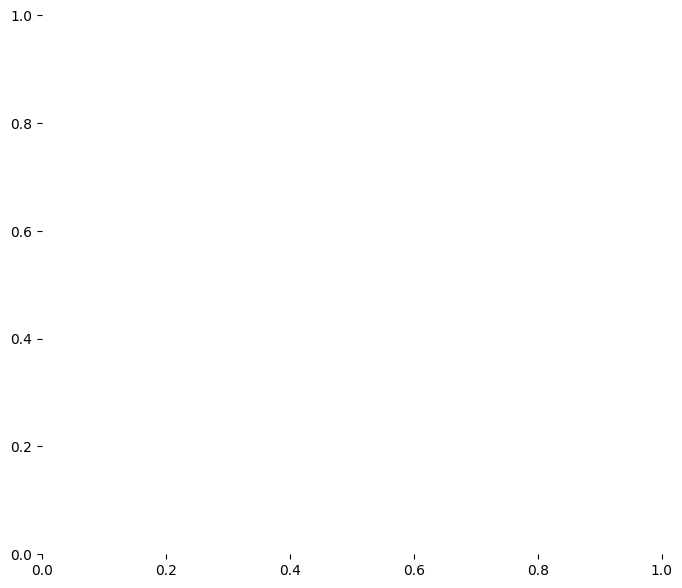

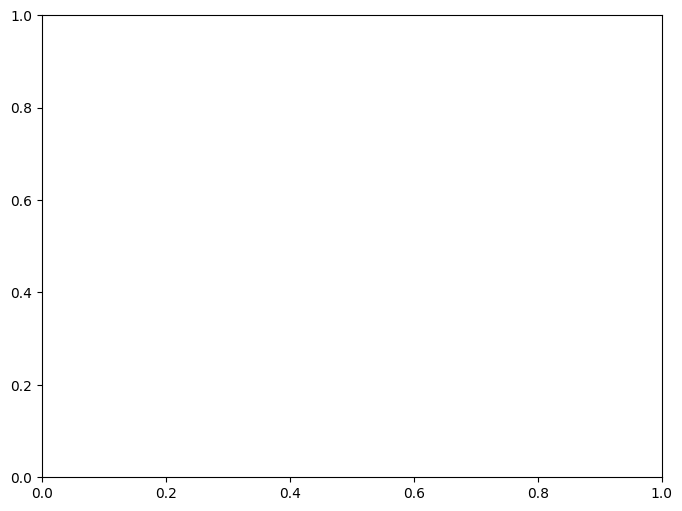

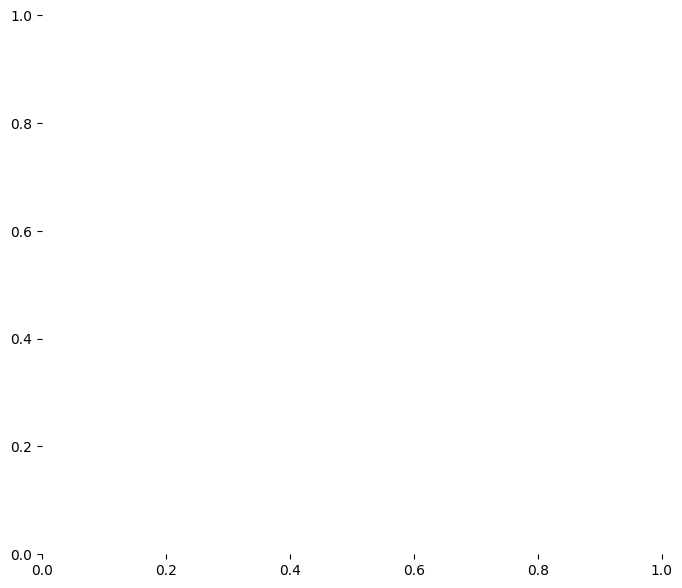

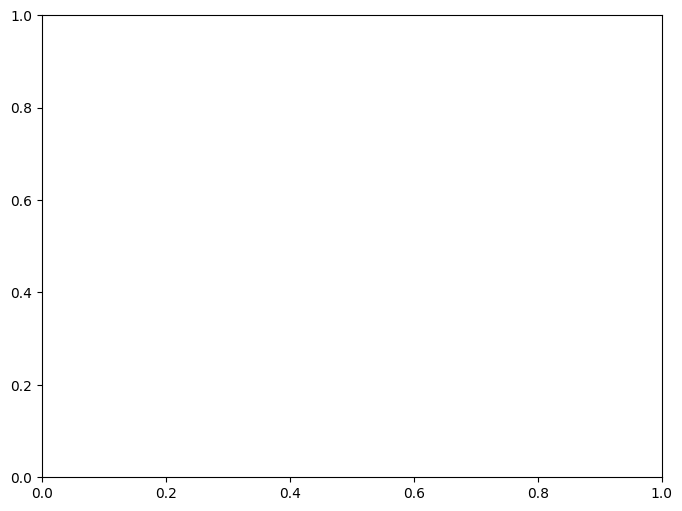

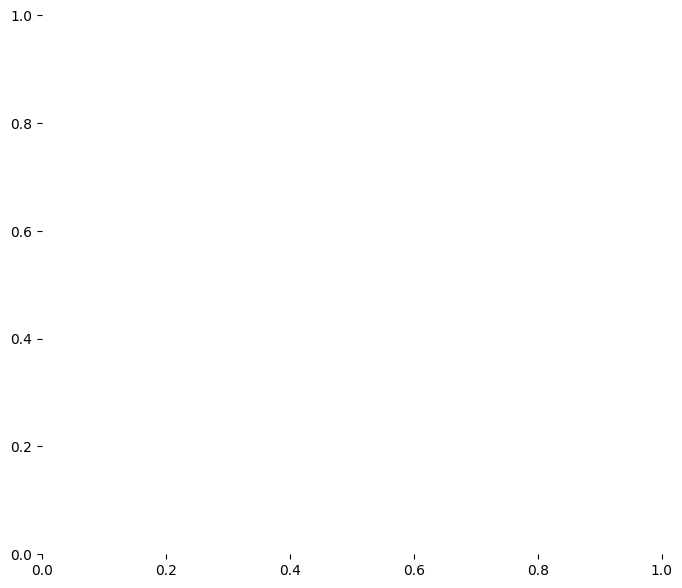

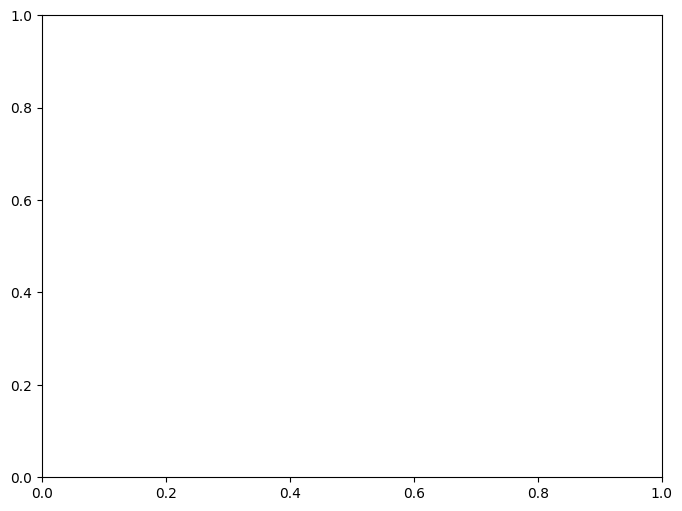

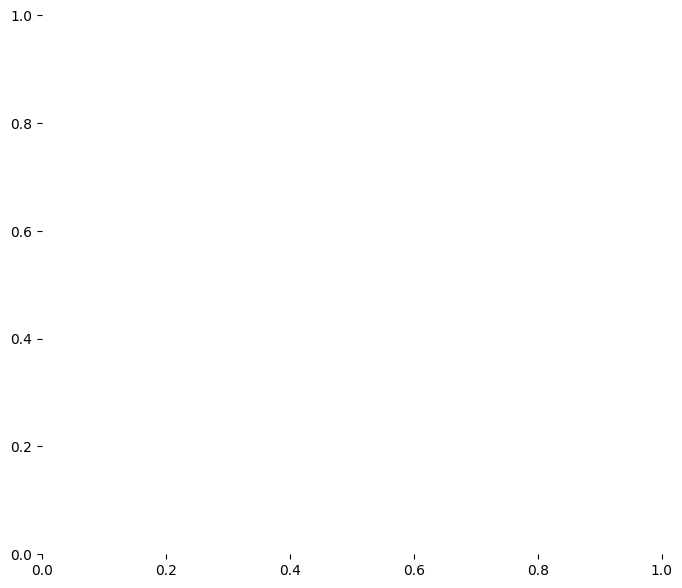

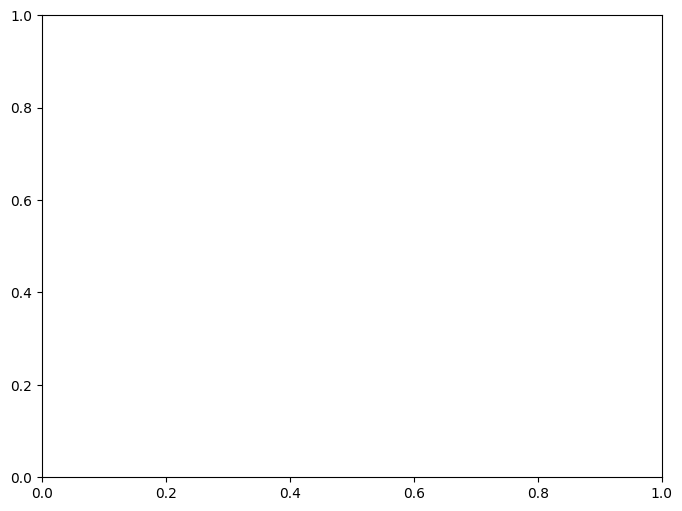

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import seaborn as sns

dataset_pairs = [
    ("K562_to_K562", X_train_K562, X_test_K562),
    ("HEK293_to_HEK293", X_train_HEK293, X_test_HEK293),
    ("HeLa_to_HeLa", X_train_HeLa, X_test_HeLa),
    ("K562_HEK293_to_HeLa", df_K562_HEK293, df_HeLa),
    ("K562_HeLa_to_HEK293", df_K562_HeLa, df_HEK293),
    ("HEK293_HeLa_to_K562", df_HEK293_HeLa, df_K562)
]

# Plot ROC curves, PR curves, histograms, and confusion matrices for best models on each dataset pair
for pair_name, X_train_full, X_val_full in dataset_pairs:
    X_val, y_val = X_val_full.drop("CLASS", axis=1), X_val_full["CLASS"]
    roc_fig, roc_ax = plt.subplots()
    pr_fig, pr_ax = plt.subplots()
    cm_fig, cm_ax = plt.subplots(figsize=(8, 7))
    hist_fig, hist_ax = plt.subplots(figsize=(8, 6))

    # Retrieve the best models for the current pair
    best_models = best_results[pair_name]

    # Sort models by AUC-ROC score
    sorted_models = sorted(best_models, key=lambda item: item['auc_roc'], reverse=True)

    for model_data in sorted_models:
        model_name = model_data['model']
        model_file_path = os.path.join("models", f"{pair_name}_{model_name}_best_model.pkl")
        best_model = joblib.load(model_file_path)  # Load the trained model from the file

        # Retrieve the list of feature names used during training
        feature_names = set(best_model.feature_names_in_)

        # Select the corresponding features from X_val
        X_val_selected = X_val[X_val.columns.intersection(feature_names)]

        # Confusion Matrix
        y_pred = best_model.predict(X_val_selected)
        cm = confusion_matrix(y_val, y_pred)
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        cm_perc = cm / cm_sum.astype(float) * 100
        annot = np.empty_like(cm).astype(str)
        nrows, ncols = cm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i, j]
                p = cm_perc[i, j]
                if i == j:
                    s = cm_sum[i]
                    annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                elif c == 0:
                    annot[i, j] = ''
                else:
                    annot[i, j] = '%.1f%%\n%d' % (p, c)

        cm_df = pd.DataFrame(cm, index=np.unique(y_val), columns=np.unique(y_val))
        cm_df.index.name = 'Actual'
        cm_df.columns.name = 'Predicted'
        sns.heatmap(cm_df, annot=annot, fmt='', ax=cm_ax, cbar=False, cmap='Blues')
        cm_ax.set_title(f'Confusion Matrix\n{model_name} - {pair_name}')
        cm_file_path = os.path.join("output", f"cm_{pair_name}_{model_name}.svg")
        cm_fig.savefig(cm_file_path, bbox_inches='tight')
        cm_ax.clear()
        # print(f"The confusion matrix SVG file for {model_name} on {pair_name} was outputted successfully here: {os.path.abspath(cm_file_path)}")

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_val, best_model.predict_proba(X_val_selected)[:, 1])
        roc_auc = round(auc(fpr, tpr) * 100, 2)
        roc_ax.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc}%)')

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_val, best_model.predict_proba(X_val_selected)[:, 1])
        sort_indices = np.argsort(recall)
        precision_sorted = precision[sort_indices]
        recall_sorted = recall[sort_indices]
        pr_auc = round(auc(recall_sorted, precision_sorted) * 100, 2)
        pr_ax.plot(recall_sorted, precision_sorted, label=f'{model_name} (area = {pr_auc}%)')

        # Histogram of Predicted Probabilities
        y_proba = best_model.predict_proba(X_val_selected)[:, 1]
        hist_ax.hist([y_proba[y_val == 0], y_proba[y_val == 1]], bins=10, edgecolor='k',
                     alpha=0.7, color=['blue', 'red'], label=['Predicted 0', 'Predicted 1'])
        hist_ax.set_xlabel('Predicted Probability')
        hist_ax.set_ylabel('Frequency')
        hist_ax.set_title(f'Histogram of Predicted Probabilities\n{model_name} - {pair_name}')
        hist_ax.legend(loc='upper right')
        hist_file_path = os.path.join("output", f"hist_{pair_name}_{model_name}.svg")
        hist_fig.savefig(hist_file_path, bbox_inches='tight')
        hist_ax.clear()
        # print(f"The histogram of predicted probabilities SVG file for {model_name} on {pair_name} was outputted successfully here: {os.path.abspath(hist_file_path)}")

    roc_ax.plot([0, 1], [0, 1], 'k--')
    roc_ax.set_xlim([0.0, 1.0])
    roc_ax.set_ylim([0.0, 1.05])
    roc_ax.set_xlabel('False Positive Rate')
    roc_ax.set_ylabel('True Positive Rate')
    roc_ax.set_title(f'ROC Curve\n{pair_name}')
    roc_ax.legend(loc="lower right")

    roc_file_path = os.path.join("output", f"roc_{pair_name}.svg")
    roc_fig.savefig(roc_file_path, bbox_inches='tight')
    plt.close(roc_fig)
    # print(f"The ROC curve for {pair_name} was saved successfully here: {os.path.abspath(roc_file_path)}")

    pr_ax.set_xlabel('Recall')
    pr_ax.set_ylabel('Precision')
    pr_ax.set_title(f'Precision-Recall Curve\n{pair_name}')
    pr_ax.legend(loc="lower left")

    pr_file_path = os.path.join("output", f"pr_{pair_name}.svg")
    pr_fig.savefig(pr_file_path, bbox_inches='tight')
    plt.close(pr_fig)
    # print(f"The Precision-Recall curve for {pair_name} was saved successfully here: {os.path.abspath(pr_file_path)}")

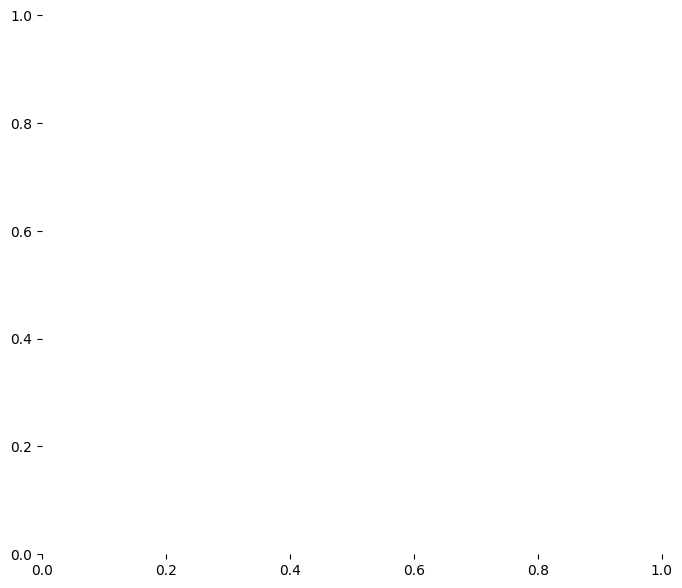

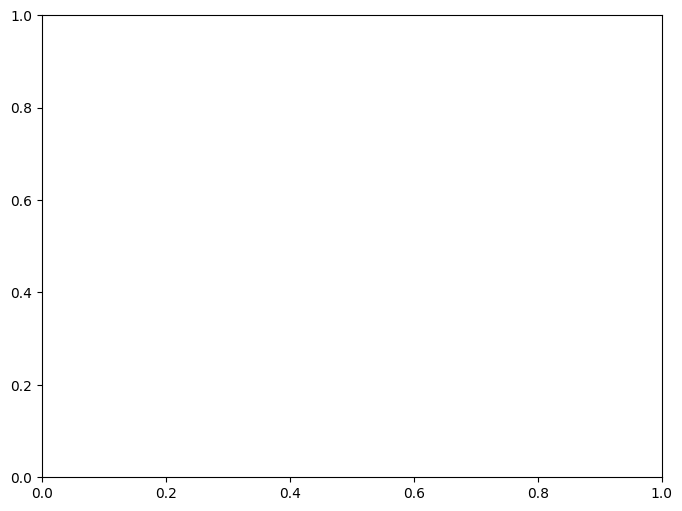

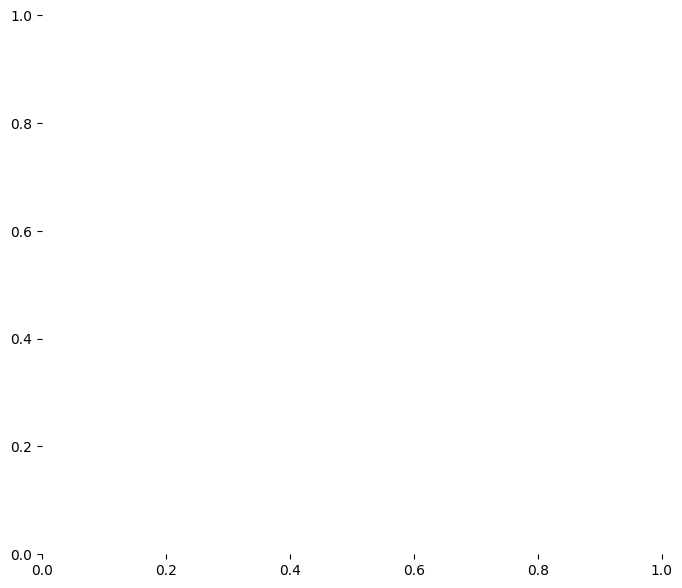

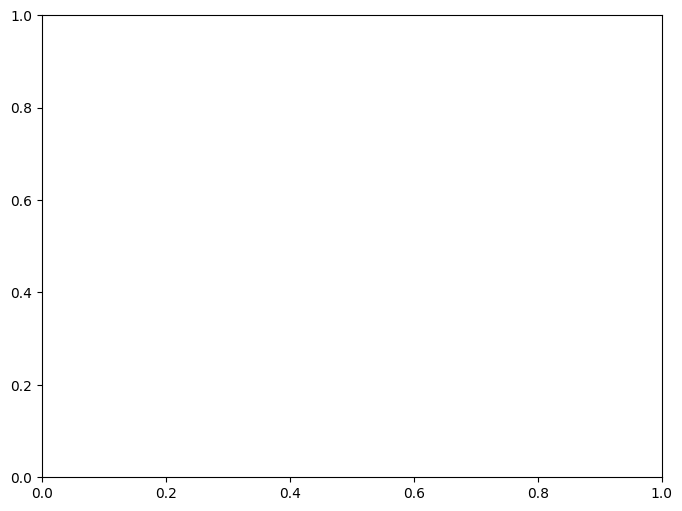

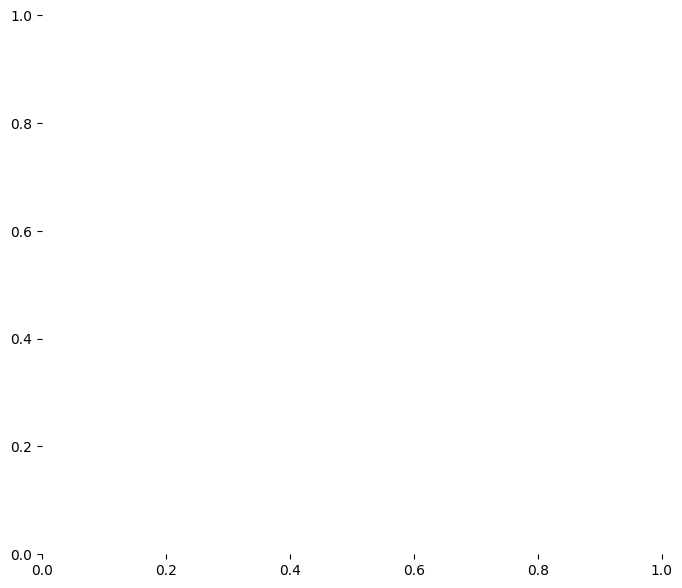

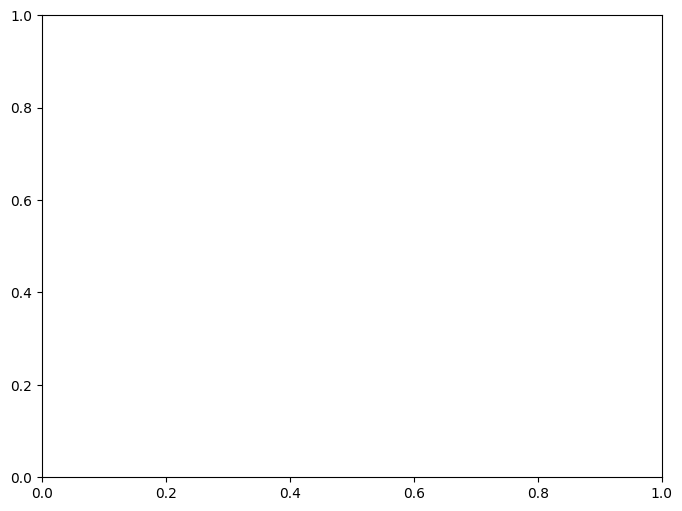

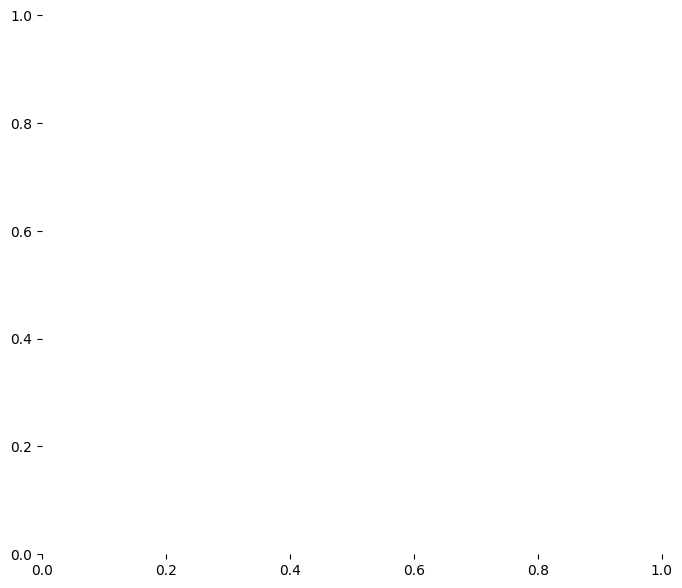

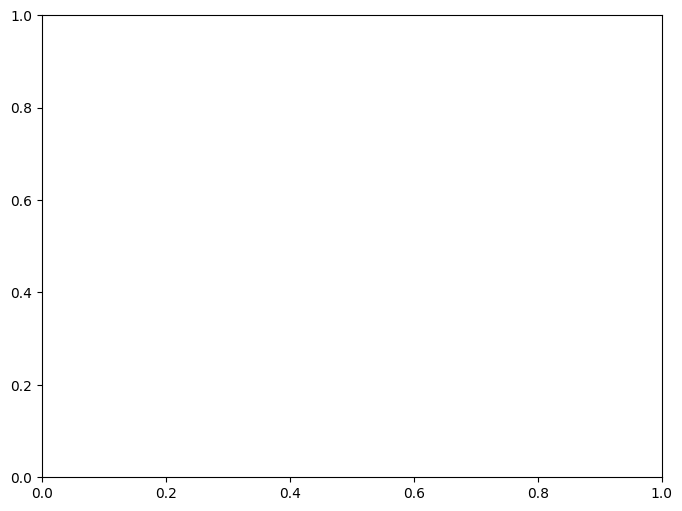

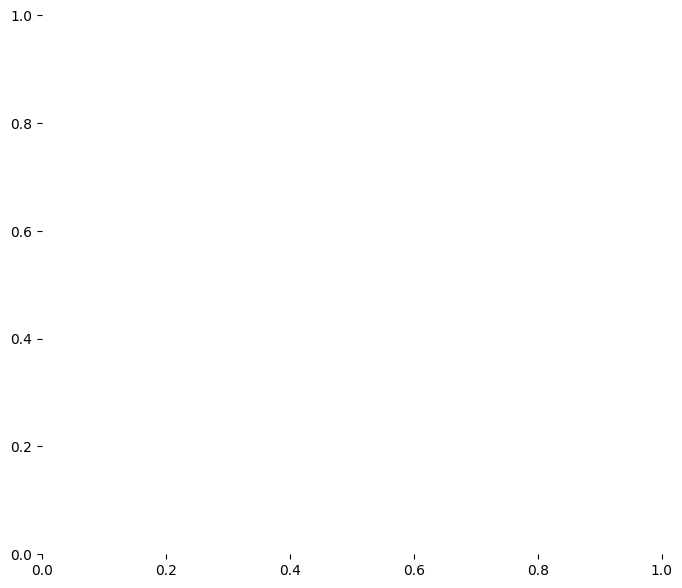

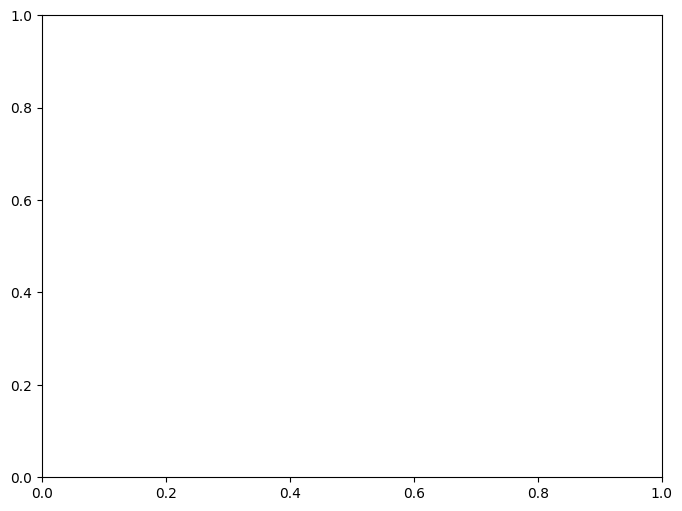

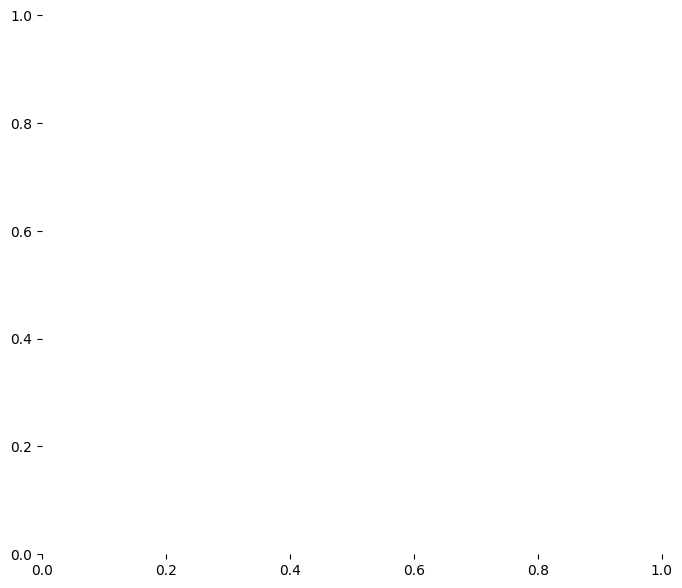

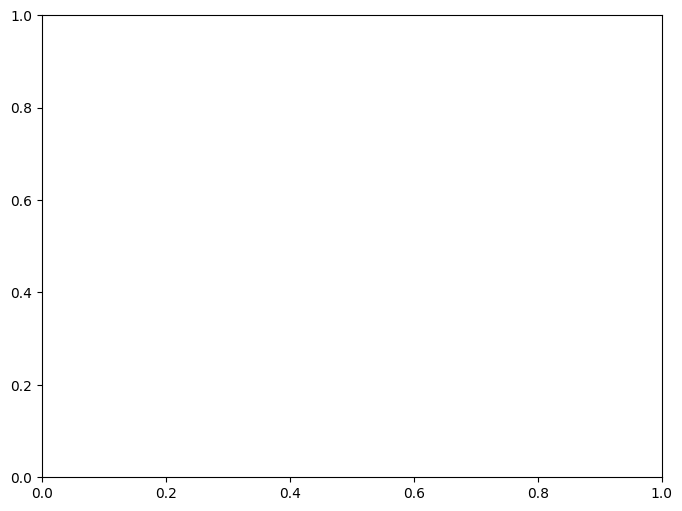

In [15]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib
import pandas as pd
import json

# Define the dataset pairs you're evaluating
dataset_pairs = [
    ("K562_to_K562", X_train_K562, X_test_K562),
    ("HEK293_to_HEK293", X_train_HEK293, X_test_HEK293),
    ("HeLa_to_HeLa", X_train_HeLa, X_test_HeLa),
    ("K562_HEK293_to_HeLa", df_K562_HEK293, df_HeLa),
    ("K562_HeLa_to_HEK293", df_K562_HeLa, df_HEK293),
    ("HEK293_HeLa_to_K562", df_HEK293_HeLa, df_K562)
]

# Ensure the output directory exists
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define consistent color mapping for models based on the provided order and colors
color_mapping = {
    'XGB': '#1f77b4',       # Blue
    'MLP': '#ff7f0e',       # Orange
    'AdaBoost': '#2ca02c',  # Green
    'GBM': '#d62728',       # Red
    'RF': '#9467bd',        # Purple
    'KNN': '#8c564b',       # Brown
    'LogReg': '#e377c2',    # Pink
    'NaiveBayes': '#7f7f7f', # Gray
    'DecisionTree': '#bcbd22'  # Yellow-green 
}

# Load best results from CSV files
best_results = {}
best_results_dir = "output_old_3"
for csv_file in os.listdir(best_results_dir):
    if csv_file.startswith("best_") and csv_file.endswith(".csv"):
        pair_name = csv_file[len("best_"):-len(".csv")]
        best_results[pair_name] = pd.read_csv(os.path.join(best_results_dir, csv_file)).to_dict(orient='records')

# Standardize legend order for all plots
legend_order = list(color_mapping.keys())

# Iterate through the dataset pairs
for pair_name, X_train_full, X_val_full in dataset_pairs:
    # Prepare the validation set
    X_val, y_val = X_val_full.drop("CLASS", axis=1), X_val_full["CLASS"]

    # Create figure containers for ROC, PR, confusion matrix, and histograms
    roc_fig, roc_ax = plt.subplots()
    pr_fig, pr_ax = plt.subplots()
    cm_fig, cm_ax = plt.subplots(figsize=(8, 7))
    hist_fig, hist_ax = plt.subplots(figsize=(8, 6))

    # Retrieve best models for the current pair
    best_models = best_results[pair_name]

    # Ensure consistent legend order
    best_models = sorted(best_models, key=lambda x: legend_order.index(x['model']))

    # Loop through the best models
    for model_data in best_models:
        model_name = model_data['model']
        model_file_path = os.path.join("models", f"{pair_name}_{model_name}_best_model.pkl")
        best_model = joblib.load(model_file_path)  # Load the trained model

        # Get feature names and select the correct columns in validation set
        feature_names = set(best_model.feature_names_in_)
        X_val_selected = X_val[X_val.columns.intersection(feature_names)]

        # Generate predictions
        y_pred = best_model.predict(X_val_selected)

        # Confusion Matrix
        cm = confusion_matrix(y_val, y_pred)
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        cm_perc = cm / cm_sum.astype(float) * 100
        annot = np.empty_like(cm).astype(str)
        nrows, ncols = cm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i, j]
                p = cm_perc[i, j]
                if i == j:
                    s = cm_sum[i]
                    annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                elif c == 0:
                    annot[i, j] = ''
                else:
                    annot[i, j] = '%.1f%%\n%d' % (p, c)

        cm_df = pd.DataFrame(cm, index=np.unique(y_val), columns=np.unique(y_val))
        cm_df.index.name = 'Actual'
        cm_df.columns.name = 'Predicted'
        sns.heatmap(cm_df, annot=annot, fmt='', ax=cm_ax, cbar=False, cmap='Blues')
        cm_ax.set_title(f'Confusion Matrix\n{model_name} - {pair_name}')
        cm_file_path = os.path.join(output_dir, f"cm_{pair_name}_{model_name}.svg")
        cm_fig.savefig(cm_file_path, bbox_inches='tight')
        cm_ax.clear()

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_val, best_model.predict_proba(X_val_selected)[:, 1])
        roc_auc = round(auc(fpr, tpr) * 100, 2)
        roc_ax.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc}%)', color=color_mapping[model_name])

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_val, best_model.predict_proba(X_val_selected)[:, 1])
        sort_indices = np.argsort(recall)
        precision_sorted = precision[sort_indices]
        recall_sorted = recall[sort_indices]
        pr_auc = round(auc(recall_sorted, precision_sorted) * 100, 2)
        pr_ax.plot(recall_sorted, precision_sorted, label=f'{model_name} (area = {pr_auc}%)', color=color_mapping[model_name])

        # Histogram of Predicted Probabilities
        y_proba = best_model.predict_proba(X_val_selected)[:, 1]
        hist_ax.hist([y_proba[y_val == 0], y_proba[y_val == 1]], bins=10, edgecolor='k',
                     alpha=0.7, color=['#1f77b4', '#ff7f0e'],  # Blue for 0, Orange for 1
                     label=['Predicted 0', 'Predicted 1'])
        hist_ax.set_xlabel('Predicted Probability')
        hist_ax.set_ylabel('Frequency')
        hist_ax.set_title(f'Histogram of Predicted Probabilities\n{model_name} - {pair_name}')
        hist_ax.legend(loc='upper right')
        hist_file_path = os.path.join(output_dir, f"hist_{pair_name}_{model_name}.svg")
        hist_fig.savefig(hist_file_path, bbox_inches='tight')
        hist_ax.clear()

    # Finalize ROC and PR plots
    roc_ax.plot([0, 1], [0, 1], 'k--')
    roc_ax.set_xlim([0.0, 1.0])
    roc_ax.set_ylim([0.0, 1.05])
    roc_ax.set_xlabel('False Positive Rate')
    roc_ax.set_ylabel('True Positive Rate')
    roc_ax.set_title(f'ROC Curve\n{pair_name}')
    roc_ax.legend(loc="lower right")

    roc_file_path = os.path.join(output_dir, f"roc_{pair_name}.svg")
    roc_fig.savefig(roc_file_path, bbox_inches='tight')
    plt.close(roc_fig)

    pr_ax.set_xlabel('Recall')
    pr_ax.set_ylabel('Precision')
    pr_ax.set_title(f'Precision-Recall Curve\n{pair_name}')
    pr_ax.legend(loc="lower left")

    pr_file_path = os.path.join(output_dir, f"pr_{pair_name}.svg")
    pr_fig.savefig(pr_file_path, bbox_inches='tight')
    plt.close(pr_fig)
